In [1]:
!git clone https://github.com/mratanusarkar/Learning-DeepLearning.git &> /dev/null
%cd /content/Learning-DeepLearning/Neural\ Networks\ -\ Zero\ to\ Hero
!python setup.py install &> /dev/null

/content/Learning-DeepLearning/Neural Networks - Zero to Hero


In [2]:
import random
random.seed(2023)

from micrograd.engine import Value
from micrograd.visualize import draw_dot, trace

# Collecting Model Parameters

In [3]:
# let's add a mechanism to our nn classes to collect model parameters
# by adding parameters method to collect model parameters (weights & biases)

In [4]:
# Karpathy's micrograd Neuron, Layer and MLP for Noobs!
class NoobNeuron:

    def __init__(self, n_inputs, label='') -> None:
        self.label = label
        self.w = [Value(random.uniform(-1,1)) for _ in range(n_inputs)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x) -> Value:
        sum = Value(0.0, label=f'{self.label} : sum')
        for i, (xi, wi) in enumerate(zip(x, self.w)):
            x = xi if isinstance(xi, Value) else Value(xi)
            x.label=f'{self.label} : x{i}'
            w = wi;         w.label=f'{self.label} : w{i}'
            den = x * w;    den.label=f'{self.label} : den{i}'
            sum = sum + den;

        b = self.b;     b.label=f'{self.label} : b'
        body = sum + b;     body.label=f'{self.label} : body'
        out = body.tanh()
        out.label=f'{self.label} : out'

        return out
    
    def parameters(self):
        # return a list of params of the neuron: w & b
        params = self.w + [self.b]
        return params

class NoobLayer:

    def __init__(self, n_neurons_prev, n_neurons_curr, label='') -> None:
        self.label = label
        self.neurons = [NoobNeuron(n_neurons_prev, f'{self.label} N:{i}') for i in range(n_neurons_curr)]

    def __call__(self, x) -> list[Value]:
        outs = [n(x) for n in self.neurons]
        return outs
    
    def parameters(self):
        # return an extended list of all params in all the neurons of the layer
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class NoobMLP:
    
    def __init__(self, n_inputs, neurons_per_layer, label='') -> None:
        self.label = label
        layer_sizes = [n_inputs] + neurons_per_layer
        self.layers = [NoobLayer(layer_sizes[i], layer_sizes[i+1], f'{self.label} L:{i+1}') for i in range(len(neurons_per_layer))]

    def __call__(self, x) -> list[Value]:
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        # return an extended list of all params in all the layers of the mlp
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params

In [5]:
# original micrograd Neuron that is similar to PyTorch API
class Neuron:

    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # out = f( sum(weights.input_xs + bias) )
        body = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = body.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        outs = outs[0] if len(outs) == 1 else outs
        return outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self, nin, nouts) -> None:
        sizes = [nin] + nouts
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [6]:
n = NoobMLP(3, [4, 4, 1], 'classifier')

data = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

target = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x)[0] for x in data]

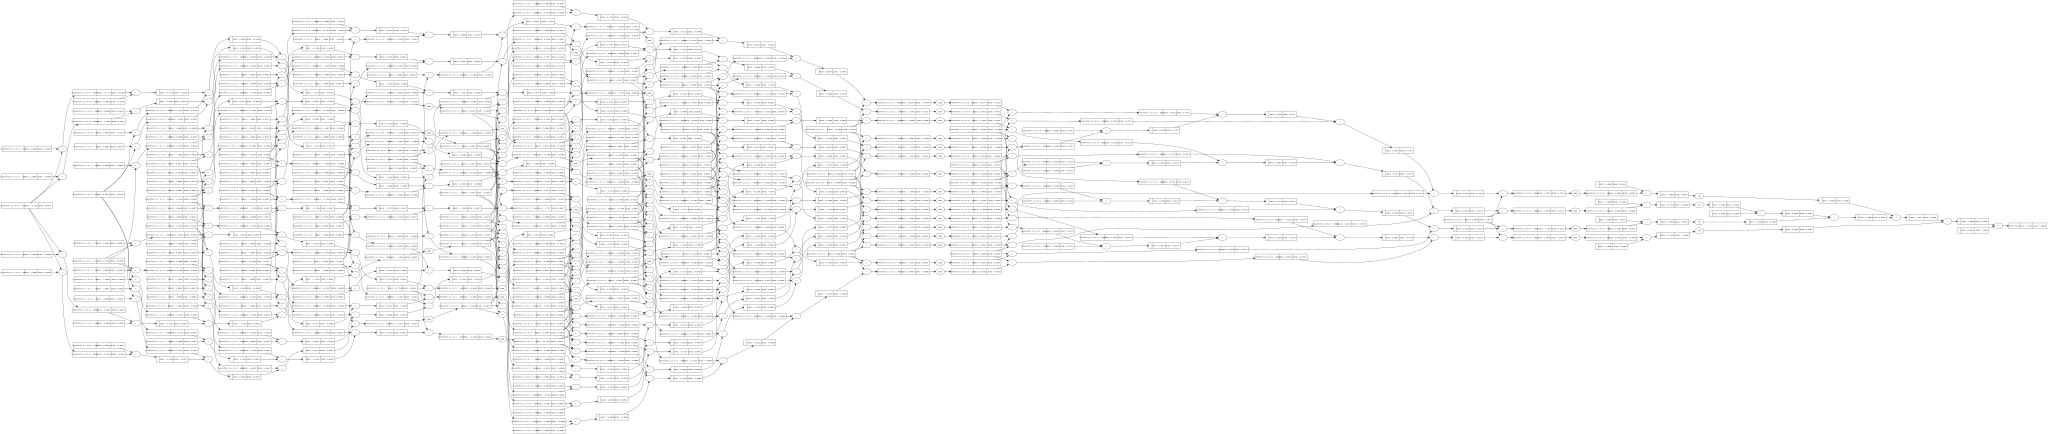

In [7]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(target, ypred)) / 4
loss.label='mse loss'
loss.backward()
draw_dot(loss)

In [8]:
# let's get the parameters from our neural network!
n.parameters()

[Value(label=classifier L:1 N:0 : w0, data=-0.2341561510915824, grad=0.00189345391364902),
 Value(label=classifier L:1 N:0 : w1, data=0.9437241769815645, grad=-0.0124965727190401),
 Value(label=classifier L:1 N:0 : w2, data=0.6876348464076729, grad=-0.011440878971193343),
 Value(label=classifier L:1 N:0 : b, data=-0.35943872315862, grad=-0.010705070284567061),
 Value(label=classifier L:1 N:1 : w0, data=0.14205147226820958, grad=-0.0033325948654878545),
 Value(label=classifier L:1 N:1 : w1, data=-0.3255295808113874, grad=0.012776230622085417),
 Value(label=classifier L:1 N:1 : w2, data=-0.7999046029971777, grad=-0.011676374818125213),
 Value(label=classifier L:1 N:1 : b, data=-0.752240707709926, grad=-0.002292718420227397),
 Value(label=classifier L:1 N:2 : w0, data=-0.3932557577131788, grad=0.004895815943537846),
 Value(label=classifier L:1 N:2 : w1, data=0.39357846277644915, grad=-0.0003478840452417107),
 Value(label=classifier L:1 N:2 : w2, data=0.4367290217816242, grad=0.00586148800

In [9]:
# so we see from the labels of the Values returned,
# all the w and b collected and returned from all the neurons in every layer of our mlp

# let's count how many parameters our model has in total:
print("so our model has in total of :", len(n.parameters()), "parameters")

so our model has in total of : 41 parameters


In [10]:
# let's verify MLP class too. (no point in printing the values, as the labels will be null)
n = MLP(3, [4, 4, 1])
print("using MLP, total number of parameters :", len(n.parameters()))

using MLP, total number of parameters : 41


In [11]:
# so both the implementations work!
# we can do a quick manual calculation too, to verify:

# our model had 3 inputs, then layers with 4, 4, 1 number of neurons
# so, (3x4 w + 4 b) + (4x4 w + 4 b) + (4x1 w + 1 b)
# => (12 + 4) + (16 + 4) + (4 + 1)
# => 16 + 20 + 5
# => 41
# (we can also verify the same from `n.parameters()` above)

# and there you go! it works!

In [12]:
# let's update our micrograd module with this changes and continue with nn ...